In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(dpi=150)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [3]:
# importing and preparing the dataset
!wget --load-cookies /tmp/data_lab.zip "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/data_lab.zip --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1" -O data_lab.zip && rm -rf /tmp/data_lab.zip

print('Unzipping folder... this may take a few minutes without output. Be patient.')
with zipfile.ZipFile('data_lab.zip', 'r') as zip_ref:
    zip_ref.extractall('data_lab')

path_data = '/content/data_lab/data_lab'
train_dir = os.path.join(path_data, 'train')
validation_dir = os.path.join(path_data, 'valid')
test_dir = os.path.join(path_data, 'test')
print('Directories in unzipped folder:', os.listdir(path_data))


train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(598, 598))
class_names = train_dataset.class_names

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(598, 598))

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=32,
                                            image_size=(598, 598))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

--2023-11-10 09:46:48--  https://docs.google.com/uc?export=download&confirm=t&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1
Resolving docs.google.com (docs.google.com)... 108.177.13.100, 108.177.13.102, 108.177.13.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kcv9qnpsf3975oikjie7u6pth04khdc/1699609575000/13525664275705142765/*/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download&uuid=b47f616f-dca1-4d4e-bf21-78f1cf1cfcce [following]
--2023-11-10 09:46:48--  https://doc-04-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kcv9qnpsf3975oikjie7u6pth04khdc/1699609575000/13525664275705142765/*/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download&uuid=b47f616f-dca1-4d4e-bf21-78f1cf1cfcce
Resolving doc-04-48-docs.googleusercontent.com (doc-04-48-docs.googleusercontent.com)... 173.194.218.132,

In [17]:
# defining data augmentation, potentially can add more different ones

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()


Number of layers in the base model:  154
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 598, 598, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 598, 598, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 598, 598, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 598, 598, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                  

Epoch 1/50
5/5 [==============================] - 81s 16s/step - loss: 0.8057 - accuracy: 0.5500 - val_loss: 0.8243 - val_accuracy: 0.4875
Epoch 2/50
5/5 [==============================] - 71s 16s/step - loss: 0.8574 - accuracy: 0.4750 - val_loss: 0.7976 - val_accuracy: 0.4875
Epoch 3/50
5/5 [==============================] - 73s 16s/step - loss: 0.7986 - accuracy: 0.4875 - val_loss: 0.7391 - val_accuracy: 0.5125
Epoch 4/50
5/5 [==============================] - 72s 17s/step - loss: 0.7834 - accuracy: 0.5000 - val_loss: 0.8006 - val_accuracy: 0.4250
Epoch 5/50
5/5 [==============================] - 54s 12s/step - loss: 0.7620 - accuracy: 0.4500 - val_loss: 0.7012 - val_accuracy: 0.5375
Epoch 6/50
5/5 [==============================] - 54s 12s/step - loss: 0.7673 - accuracy: 0.5375 - val_loss: 0.7217 - val_accuracy: 0.4625
Epoch 7/50
5/5 [==============================] - 71s 16s/step - loss: 0.7246 - accuracy: 0.4750 - val_loss: 0.6798 - val_accuracy: 0.5250
Epoch 8/50
5/5 [===========

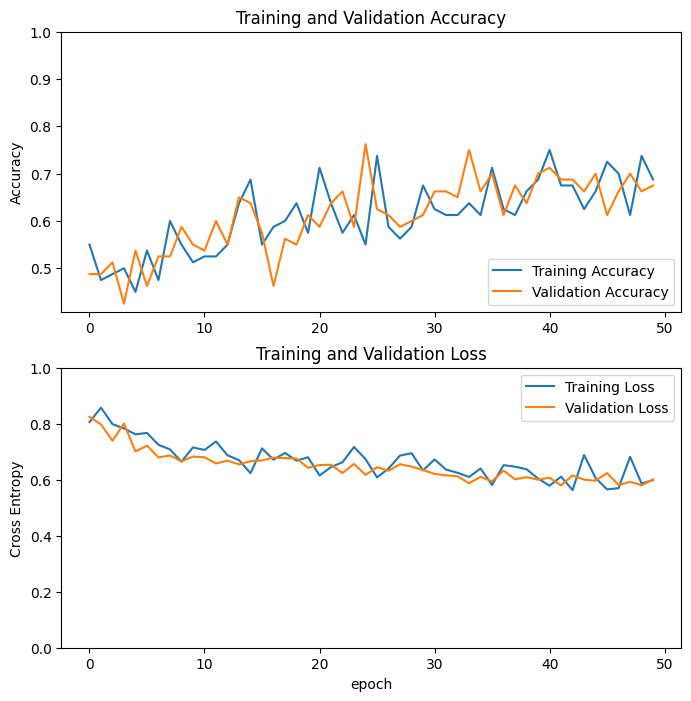

In [18]:
history = model.fit(train_dataset,
                    steps_per_epoch=25,
                    validation_steps=50,
                    epochs=20,
                    validation_data=validation_dataset)

plot_history(history)
